In [1]:
import random
import pandas as pd
import numpy as np
from scipy.stats import norm

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from SyncRNG import SyncRNG
import numpy as np
import re
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy import linalg
from itertools import chain

from SyncRNG import SyncRNG

from CTL.causal_tree_learn import CausalTree
from sklearn.model_selection import train_test_split
import plotnine as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'CTL'

# HTE I: Binary treatment

Source RMD file: [link](https://docs.google.com/uc?export=download&id=1FSUi4WLfYYKnvWsNWypiQORhkqf5IlFP)

In the previous chapter, we learned how to estimate the effect of a binary treatment averaged over the entire population. However, the average may obscure important details about how different individuals react to the treatment. In this chapter, we will learn how to estimate the **conditional average treatment effect (CATE)**,

$$
  \tau(x) := \mathbf{E}[Y_i(1) - Y_i(0) | X_i = x],
$$ (cate)

which is a "localized" version of the average treatment effect conditional on a vector of observable characteristics. 

It's often the case that {eq}`cate` is too general to be immediately useful, especially when the observable covariates are high-dimensional. It can be hard to estimate reliably without making strong modeling assumptions, and hard to summarize in a useful manner after estimation. In such situations, we will instead try to estimate treatment effect averages for simpler groups

$$
  \mathbf{E}[Y_i(1) - Y_i(0) | G_i = g],
$$ (cate-g)

where $G_i$ indexes subgroups of interest. Below you'll learn how to estimate and test hypotheses about pre-defined subgroups, and also how to discover subgroups of interest from the data. In this tutorial, you will learn how to use estimates of {eq}`cate` to suggest relevant subgroups $G_i$ (and in the next chapters you will find out other uses of {eq}`cate` in policy learning and evaluation).

We'll continue using the abridged version of the General Social Survey (GSS) [(Smith, 2016)](https://gss.norc.org/Documents/reports/project-reports/GSSProject%20report32.pdf) dataset that was introduced in the previous chapter. In this dataset, individuals were sent to treatment or control with equal probability, so we are in a randomized setting. However, many of the techniques and code shown below should also work in an observational setting provided that unconfoundedness and overlap are satisfied (these assumptions were defined in the previous chapter).

As with other chapters in this tutorial, the code below should still work by replacing the next snippet of code with a different dataset, provided that you update the key variables `treatment`, `outcome`, and `covariates` below. Also, please make sure to read the comments as they may be subtle differences depending on whether your dataset was created in a randomized or observational setting.

In [2]:
data = pd.read_csv( "https://docs.google.com/uc?id=1kSxrVci_EUcSr_Lg1JKk1l7Xd5I9zfRC&export=download" )

n = data.shape[0]

# Treatment: does the the gov't spend too much on "welfare" (1) or "assistance to the poor" (0)
treatment = "w"

# Outcome: 1 for 'yes', 0 for 'no'
outcome = "y"

# Additional covariates
covariates = ["age", "polviews", "income", "educ", "marital", "sex"]

## Pre-specified hypotheses

We will begin by learning how to test pre-specified null hypotheses of the form

$$
  H_{0}: \mathbf{E}[Y(1) - Y(0) | G_i = 1] = \mathbf{E}[Y(1) - Y(0) | G_i = 0].
$$ (hte-hyp)

That is, that the treatment effect is the same regardless of membership to some group
$G_i$. Importantly, for now we’ll assume that the group $G_i$ was **pre-specified** -- it was decided _before_ looking at the data.

In a randomized setting, if the both the treatment  $W_i$ and group membership $G_i$ are binary, we can write

$$
  \mathbf{E}[Y_i(W_i)|G_i] = \mathbf{E}[Y_i|W_i, G_i] = \beta_0 + \beta_w W_i + \beta_g G_i + \beta_{wg} W_i G_i
$$ (linear)

<font size=1>
When $W_i$ and $G_i$ are binary, this decomposition is true without loss of generality. Why?
</font>

This allows us to write the average effects of $W_i$ and $G_i$ on $Y_i$ as

$$
  \begin{aligned}
    \mathbf{E}[Y(1) | G_i=1] &= \beta_0 + \beta_w W_i + \beta_g G_i + \beta_{wg} W_i G_i, \\
    \mathbf{E}[Y(1) | G_i=0] &= \beta_0 + \beta_w W_i,  \\
    \mathbf{E}[Y(0) | G_i=1] &= \beta_0 + \beta_g G_i,  \\
    \mathbf{E}[Y(0) | G_i=0] &= \beta_0.
  \end{aligned}
$$ (decomp)

Rewriting the null hypothesis {eq}`hte-hyp` in terms of the decomposition {eq}`decomp`, we see that it boils down to a test about the coefficient in the interaction: $\beta_{xw} = 0$. Here’s an example that tests whether the treatment effect is the same for "conservative" (`polviews` < 4) and "liberal" (`polviews` $\geq$ 4) individuals.

In [3]:
# Only valid in randomized settings

# Suppose this his group was defined prior to collecting the data
data["conservative"] = np.multiply(data.polviews < 4, 1)  # a binary group
group = 'conservative'

# Recall from last chapter -- this is equivalent to running a t-test
fmla = 'y ~ w*conservative'
ols = smf.ols(fmla, data=data).fit(cov_type='HC2')
# print(ols_1.summary())
hypotheses = 'Intercept=0, w=0, conservative=0, w:conservative=0'
t_test = ols.t_test(hypotheses)
print(t_test.summary(xname=list(ols.summary2().tables[1].index)))

                               Test for Constraints                               
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4836      0.005     95.127      0.000       0.474       0.494
w                 -0.3789      0.006    -64.657      0.000      -0.390      -0.367
conservative      -0.1590      0.009    -17.195      0.000      -0.177      -0.141
w:conservative     0.1160      0.010     11.185      0.000       0.096       0.136


<font size=1>
Interpret the results above. The coefficient $\beta_{xw}$ is denoted by `w:conservativeTRUE`. Can we detect a difference in treatment effect for conservative vs liberal individuals? For whom is the effect larger?
</font>


Sometimes there are many subgroups, leading to multiple hypotheses such as

$$
H_0: \mathbf{E}[Y(1) - Y(0) \ | \  G_i = 1] = \mathbf{E}[Y(1) - Y(0) \ | \  G_i = g]
\qquad
\text{for many values of }g.
$$ (mult-hyp)

In that case, we need to correct for the fact that we are testing for multiple hypotheses, or we will end up with many false positives. The **Bonferroni correction** [(wiki)](https://en.wikipedia.org/wiki/Bonferroni_correction) is a common method for dealing with multiple hypothesis testing, though it is often too conservative to be useful. It is available via the function `p.adjust` from base `R`. The next snippet of code tests whether the treatment effect at each level of `polviews` is different from the treatment effect from `polviews` equals one.

In [4]:
# Only valid in randomized setting.

# Example: these groups must be defined prior to collecting the data.
group = 'polviews'

# Linear regression.
fmla = 'y ~ w*C(polviews)'
ols = smf.ols(fmla, data=data).fit(cov_type='HC2')

# Retrieve the interaction coefficients
ols_1 = ols.summary2().tables[1].reset_index()
interact = ols_1.loc[ols_1["index"].str.contains("w:")]

hypothesis_1 = []
for i in list(interact['index']):
    hypothesis_1.append(i+str('=0'))
hypotheses = hypothesis_1
t_test = ols.t_test(hypotheses)
# print(t_test.summary(xname=list(interact['index'])))

# Retrieve unadjusted p-values and 
unadj_p_value = list(interact["P>|z|"])
p_adjusted = list(multipletests(unadj_p_value, alpha=0.05, method='bonferroni')[1])

pd.DataFrame(zip(interact["Coef."], interact["Std.Err."], unadj_p_value, p_adjusted),
               columns =['Estimate', 'Std.Err.', 'unadj_p_value', 'adj_p_value'],
            index = list(interact["index"]))

,Estimate,Std.Err.,unadj_p_value,adj_p_value
w:C(polviews)[T.2],-0.024242,0.027337,3.751982e-01,1.000000e+00
w:C(polviews)[T.3],-0.059623,0.027357,2.929996e-02,1.757997e-01
w:C(polviews)[T.4],-0.134614,0.025340,1.082607e-07,6.495642e-07
w:C(polviews)[T.5],-0.164915,0.027135,1.220112e-09,7.320672e-09
w:C(polviews)[T.6],-0.180079,0.027514,5.952137e-11,3.571282e-10
w:C(polviews)[T.7],-0.186184,0.038706,1.507202e-06,9.043211e-06


In [5]:
# Define a function which turn a list or vector-like object into a proper two
# dimensional column vector

def cvec(a):
    """ Turn a list or vector-like object into a proper column vector
    Input
    a: List or vector-like object, has to be a potential input for np.array()
    Output
    vec: two dimensional NumPy array, with the first dimension weakly greater
         than the second (resulting in a column vector for a vector-like input)
    """
    # Conver input into a two dimensional NumPy array
    vec = np.array(a, ndmin=2)

    # Check whether the second dimension is strictly greater than the first
    # (remembering Python's zero indexing)
    if vec.shape[0] < vec.shape[1]:
        # If so, transpose the input vector
        vec = vec.T

    # Return the column vector
    return vec


In [6]:
def get_cov(X, e, add_intercept=True, homoskedastic=False):
    """ Calculates OLS variance estimator based on X and residuals
    Inputs
    X: n by k matrix, RHS variables
    e: n by 1 vector or vector-like, residuals from an OLS regression
    add_intercept: Boolean, if True, adds an intercept as the first column of X
                   (and increases k by one)
    Outputs
    V_hat: k by k NumPy array, estimated covariance matrix
    """
    # Get the number of observations n and parameters k
    n, k = X.shape

    # Check whether an intercept needs to be added
    if add_intercept:
        # If so, add the intercept
        X = np.concatenate([np.ones(shape=(n,1)), X], axis=1)

        # Don't forget to increase k
        k = k + 1

    # Make sure the residuals are a proper column vector
    e = cvec(e)

    # Calculate X'X
    XX = X.T @ X

    # Calculate its inverse
    XXinv = linalg.inv(XX)

    # Check whether to use homoskedastic errors
    if homoskedastic:
        # If so, calculate the homoskedastic variance estimator
        V_hat = (1 / (n-k)) * XXinv * (e.T @ e)
    else:
        # Otherwise, calculate an intermediate object
        S = (e @ np.ones(shape=(1,k))) * X

        # Then, get the HC0 sandwich estimator
        V_hat = (n / (n-k)) * XXinv @ (S.transpose() @ S) @ XXinv

    # Return the result
    return V_hat

In [7]:
# Auxiliary function to computes adjusted p-values 
# following the Romano-Wolf method.
# For a reference, see http://ftp.iza.org/dp12845.pdf page 8
#  t.orig: vector of t-statistics from original model
#  t.boot: matrix of t-statistics from bootstrapped models


def romano_wolf_correction(t_orig, t_boot):
    abs_t_orig = np.absolute(t_orig)
    abs_t_boot = np.absolute(t_boot)
    abs_t_sorted = sorted(abs_t_orig, key = float, reverse=True)

    max_order = (-np.array(abs_t_orig)).argsort()
    rev_order = np.argsort(max_order)

    M = t_boot.shape[0]
    S = t_boot.shape[1]

    p_adj = list(np.repeat(0, S))
    p_adj[0] = np.mean(pd.DataFrame(abs_t_boot).apply(np.max, axis=1) > abs_t_sorted[0])

    for s in range(1,S):
        cur_index = max_order[s:S]
        p_init = np.mean(
            pd.DataFrame(abs_t_boot).T.iloc[cur_index].T.apply(np.max, axis=1) > abs_t_sorted[s])
        p_adj[s] = np.max(p_init, p_adj[s])

    aux = []
    for i in rev_order:
        aux.append(p_adj[i])

    p_adj = aux
    
    return(p_adj)

In [8]:
# Computes adjusted p-values for linear regression (lm) models.
#    model: object of lm class (i.e., a linear reg model)
#    indices: vector of integers for the coefficients that will be tested
#    cov.type: type of standard error (to be passed to sandwich::vcovHC)
#    num.boot: number of null bootstrap samples. Increase to stabilize across runs.
# Note: results are probabilitistic and may change slightly at every run. 
#
# Adapted from the p_adjust from from the hdm package, written by Philipp Bach.
# https://github.com/PhilippBach/hdm_prev/blob/master/R/p_adjust.R

def summary_rw_lm(model, indices='', cov_type="HC2", num_boot=10000):
    SyncRNG(seed = 123456)  

    # OLS without correction

    # Grab the original t values.
    ols = smf.ols(fmla, data=data).fit()
    ols = ols.summary2().tables[1].reset_index()
    summary = ols[ols['index'].isin(list(indices["index"]))]
    t_orig = summary['t']

    # Null resampling.
    # This is a trick to speed up bootstrapping linear models.
    # Here, we don't really need to re-fit linear regressions, which would be a bit slow.
    # We know that betahat ~ N(beta, Sigma), and we have an estimate Sigmahat.
    # So we can approximate "null t-values" by
    #  - Draw beta.boot ~ N(0, Sigma-hat) --- note the 0 here, this is what makes it a *null* t-value.
    #  - Compute t.boot = beta.boot / sqrt(diag(Sigma.hat))

    ols = smf.ols(fmla, data=data).fit(cov_type = cov_type)
    ols_exog = smf.ols(fmla, data=data).exog
    ols_res = smf.ols(fmla, data=data).fit().resid
    Sigma_hat = get_cov(ols_exog, ols_res, add_intercept=False)

    se_orig = pd.Series(np.sqrt(Sigma_hat.diagonal()))

    num_coef = len(se_orig)

    beta_boot = pd.DataFrame(
                np.random.multivariate_normal(
                mean=np.repeat(0, num_coef), cov=Sigma_hat, size=num_boot))

    t_boot = np.array(beta_boot.apply(lambda row: row / se_orig, axis=1))
    t_boot = t_boot.T[(len(ols_1)-len(t_orig)):len(ols_1)].T

    p_adj = romano_wolf_correction(t_orig, t_boot)
    result = summary[['index','Coef.','Std.Err.','P>|t|']]
    result.rename(columns={'P>|t|': 'Orig.p-value'}, inplace=True)
    result['Adj. p-value'] = p_adj

    return(result)

In [9]:
# This linear regression is only valid in a randomized setting.
fmla = 'y ~ w*C(polviews)'
ols = smf.ols(fmla, data=data).fit()
ols = ols.summary2().tables[1].reset_index()
interact = ols.loc[ols_1["index"].str.contains("w:")]

# Applying the romano-wolf correction.
summary_rw_lm(ols, indices=interact)

C:\Users\Roberto\AppData\Local\Temp\ipykernel_19960\909325009.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Roberto\AppData\Local\Temp\ipykernel_19960\909325009.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,index,Coef.,Std.Err.,Orig.p-value,Adj. p-value
8,w:C(polviews)[T.2],-0.024242,0.030348,4.244098e-01,0.4235
9,w:C(polviews)[T.3],-0.059623,0.030150,4.798896e-02,0.0764
10,w:C(polviews)[T.4],-0.134614,0.028228,1.862258e-06,0.0000
11,w:C(polviews)[T.5],-0.164915,0.029575,2.481093e-08,0.0000
12,w:C(polviews)[T.6],-0.180079,0.029660,1.284150e-09,0.0000
13,w:C(polviews)[T.7],-0.186184,0.037904,9.063658e-07,0.0000


<font size=1>
Compare the adjusted p-values under Romano-Wolf with those obtained via Bonferroni above.
</font>

The Bonferroni and Romano-Wolf methods control the **familywise error rate (FWER)**, which is the (asymptotic) probability of rejecting even one true null hypothesis. In other words, for a significance level $\alpha$, they guarantee that with probability $1 - \alpha$ we will make zero false discoveries. However, when the number of hypotheses being tested is very large, this criterion may be so stringent that it prevents us from being able to detect real effects. Instead, there exist alternative procedures that control the (asymptotic) **false discovery rate (FDR)**, defined as the expected proportion of true null hypotheses rejected among all hypotheses rejected. One such procedure is the Benjamini-Hochberg procedure, which is available in base R via `p.adjust(..., method="BH")`. For what remains we'll stick with FWER control, but keep in mind that FDR control can also useful in exploratory analyses or settings in which there's a very large number of hypotheses under consideration.

As in the previous chapter, when working with observational data under unconfoundedness and overlap, one can use AIPW scores  $\hat{\Gamma}_i$ in place of the raw outcomes  $Y_i$. In the next snippet, we construct AIPW scores using the `causal_forest` function from the `grf` package.

## Data-driven hypotheses

Pre-specifying hypotheses prior to looking at the data is in general good practice to avoid "p-hacking" (e.g., slicing the data into different subgroups until a significant result is found). However, valid tests can also be attained if by **sample splitting**: we can use a subset of the sample to find promising subgroups, then test hypotheses about these subgroups in the remaining sample. This kind of sample splitting for hypothesis testing is called **honesty**.

### Via causal trees

**Causal trees** [(Athey and Imbens)](PNAS, 2016)](https://www.pnas.org/content/pnas/113/27/7353.full.pdf) are an intuitive algorithm that is available in the randomized setting to discover subgroups with different treatment effects.

At a high level, the idea is to divide the sample into three subsets (not necessarily of equal size). The `splitting` subset is used to fit a decision tree whose objective is modified to maximize heterogeneity in treatment effect estimates across leaves. The `estimation` subset is then used to produce a valid estimate of the treatment effect at each leaf of the fitted tree. Finally, a `test` subset can be used to validate the tree estimates.

The next snippet uses `honest.causalTree` function from the [`causalTree`](https://github.com/susanathey/causalTree) package. For more details, see the [causalTree documentation](https://github.com/susanathey/causalTree/blob/master/briefintro.pdf).

In [10]:
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.grf import CausalForest
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy
import seaborn as sns

In [11]:
from scipy.sparse import csr_matrix
from scipy import sparse

In [119]:
split = np.array_split(list(data.index),3)

X_train = data.loc[split[0],['age','polviews', 'income','educ','marital','sex']] 
y_train = data.loc[split[0],'y'] 
T_train =data.loc[split[0],'w'] 

X_est = data.loc[split[1],['age','polviews', 'income','educ','marital','sex']] 
y_est = data.loc[split[1],'y'] 
T_est =data.loc[split[1],'w'] 

X_test = data.loc[split[2],['age','polviews', 'income','educ','marital','sex']] 
y_test = data.loc[split[2],'y'] 
T_test =data.loc[split[2],'w'] 

In [124]:
# Preparing data to fit a causal forest

#fmla = '0+age+polviews+income+educ+marital+sex'
#matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")

#T = data.loc[ : ,"w"]
#Y = data.loc[ : ,"y"]X = matrix


# Estimate a causal tree using Causal Forest library

ctree = CausalForest(n_estimators=1, min_samples_leaf=170,
                       max_depth=50, inference = False,
                       verbose=0, random_state=123,subforest_size=1)

ctree.fit(X_train, T_train, y_train)

CausalForest(inference=False, max_depth=50, min_samples_leaf=170,
             n_estimators=1, random_state=123, subforest_size=1)

In [140]:
num_leaves = len(np.unique(ctree.predict(X_est))) # number of leaves 

print(num_leaves)

tau_hat = ctree.predict(X_est).flatten() # convert from N- array to 1-array

labels = [i for i in range(1,len(np.unique(tau_hat )) + 1 ) ] # label by each leaf 

# Prediction grouped by each leaf

predict1 = data.iloc[split[1],:]
predict1['tau_hat'] = tau_hat.tolist()
predict1['leaves'] = pd.Categorical(tau_hat)
predict1['leaves'] = predict1['leaves'].cat.rename_categories(labels)

9



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [143]:
# This is only valid in randomized datasets.

if num_leaves == 1 :
    
    print("Skipping since there's a single leaf.")
    
elif num_leaves == 2 :
    
    fmla = 'y ~ w*C(leaves)'
    ols = smf.ols(fmla, data=predict1).fit()
    ols = ols.summary2().tables[1].reset_index()
    summary = ols.loc[ols["index"].str.contains("w:")]
    result = summary[['index','Coef.','Std.Err.','P>|t|']]
    result.rename(columns={'P>|t|': 'Orig.p-value'}, inplace=True)
    
else:
    
# This linear regression is only valid in a randomized setting.

    fmla = 'y ~ w*C(leaves)'
    ols = smf.ols(fmla, data=predict1).fit()
    ols = ols.summary2().tables[1].reset_index()
    interact = ols.loc[ols["index"].str.contains("w:")]

    # Applying the romano-wolf correction.
    print(summary_rw_lm(ols, indices=interact))

               index     Coef.  Std.Err.  Orig.p-value  Adj. p-value
10  w:C(leaves)[T.2] -0.006448  0.030429      0.832177        0.9931
11  w:C(leaves)[T.3] -0.013501  0.037021      0.715365        0.9972
12  w:C(leaves)[T.4]  0.015477  0.030218      0.608546        0.9957
13  w:C(leaves)[T.5] -0.018966  0.036730      0.605610        0.9965
14  w:C(leaves)[T.6]  0.001973  0.030663      0.948692        0.9960
15  w:C(leaves)[T.7]  0.002009  0.031635      0.949363        0.9455
16  w:C(leaves)[T.8] -0.011408  0.042844      0.790039        0.9966
17  w:C(leaves)[T.9] -0.019500  0.039154      0.618466        0.9923



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[Text(0.5, 0, 'Leaf1'),
 Text(1.5, 0, 'Leaf2'),
 Text(2.5, 0, 'Leaf3'),
 Text(3.5, 0, 'Leaf4'),
 Text(4.5, 0, 'Leaf5'),
 Text(5.5, 0, 'Leaf6'),
 Text(6.5, 0, 'Leaf7'),
 Text(7.5, 0, 'Leaf8'),
 Text(8.5, 0, 'Leaf9')]

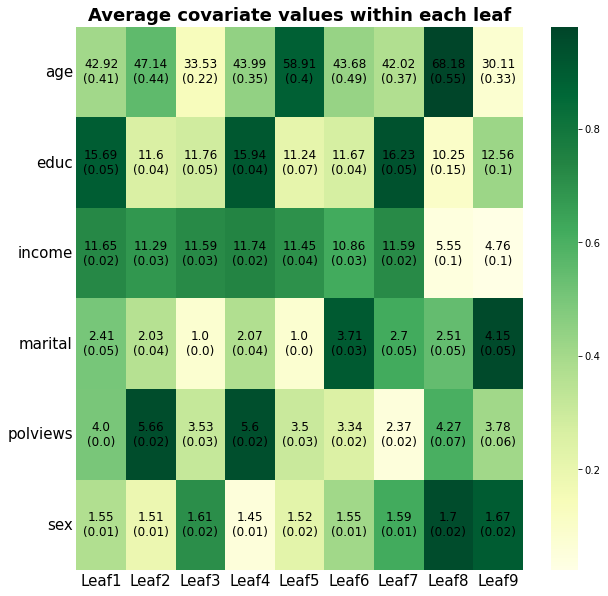

In [144]:
df = pd.DataFrame()

for var_name in covariates:
    form2 = var_name + " ~ " + "0" + "+" + "C(leaves)"
    ols = smf.ols(formula=form2, data=predict1).fit(cov_type = 'HC2').summary2().tables[1].iloc[:, 0:2]
    
    
    # Retrieve results
    toget_index = ols["Coef."]
    index = toget_index.index
    cova1 = pd.Series(np.repeat(var_name,num_leaves), index = index, name = "covariate")
    avg = pd.Series(ols["Coef."], name="avg")
    stderr = pd.Series(ols["Std.Err."], name = "stderr")
    leaves = pd.Series(np.arange(1,num_leaves+1), index = index, name = "leaves")
    scaling = pd.Series(norm.cdf((avg - np.mean(avg))/np.std(avg)), index = index, name = "scaling")
    data2 = pd.DataFrame(data=X, columns= covariates)
    variation1= np.std(avg) / np.std(data2[var_name])
    variation = pd.Series(np.repeat(variation1, num_leaves), index = index, name = "variation")
    labels = pd.Series(round(avg,2).astype('str') + "\n" + "(" + round(stderr, 2).astype('str') + ")", index = index, name = "labels")
    
    # Tally up results
    df1 = pd.DataFrame(data = [cova1, avg, stderr, leaves, scaling, variation, labels]).T
    df = df.append(df1)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df = df.sort_values(by = ["variation", "covariate"], ascending = False)

df = df.iloc[0:(8*num_leaves), :]
df1 = df.pivot(index = "covariate", columns = "leaves", values = ["scaling"]).astype(float)
labels =  df.pivot(index = "covariate", columns = "leaves", values = ["labels"]).to_numpy()

# plot heatmap
ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df1, 
                 annot=labels,
                 annot_kws={"size": 12, 'color':"k"},
                 fmt = '',
                 cmap = "YlGn",
                 linewidths=0,
                 xticklabels = leaves)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.xlabel("")
plt.ylabel("")
ax.set_title("Average covariate values within each leaf", fontsize=18, fontweight = "bold")
(ax.set_xticklabels(["Leaf1", "Leaf2", "Leaf3", "Leaf4","Leaf5", "Leaf6","Leaf7", "Leaf8", "Leaf9"], size=15))

<font size=1>
Interpret the heatmap above. What describes the subgroups with strongest and weakest estimated treatment effect?
</font>

## Causal Forest 

The function `causal_forest` from the package `CausalForest` allows us to get estimates of the CATE  (4.1). 

In [82]:
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy
import seaborn as sns

In [83]:
# Preparing data to fit a causal forest

fmla = '0+age+polviews+income+educ+marital+sex'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")

T = data.loc[ : ,"w"]
Y = data.loc[ : ,"y"]
X = matrix

# Estimate a causal forest.
est1 = CausalForest(n_estimators=2000, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

est1.fit(X, T, Y)

tau_hat = est1.predict(X).flatten()

In [84]:
# Get residuals  and propensity 
regr = RegressionForest(n_estimators=2000, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

e_hat = regr.fit(X, T).predict(X).flatten()

Text(0.5, 0, '')

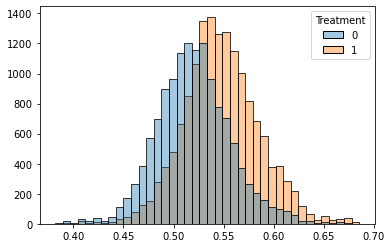

In [85]:
#Propensity score 

Prop = pd.DataFrame({"p_score":e_hat, "Treatment":T})

sns.histplot(data=Prop, x="p_score", hue="Treatment", bins=40, alpha = 0.4)

plt.ylabel('')
plt.xlabel('')

Having fit a non-parametric method such as a causal forest, a researcher may (incorrectly) start by looking at the distribution of its predictions of the treatment effect. One might be tempted to think: "if the histogram is concentrated at a point, then there is no heterogeneity; if the histogram is spread out, then our estimator has found interesting heterogeneity." However, this may be false.

Text(0.5, 1.0, 'CATE estimates')

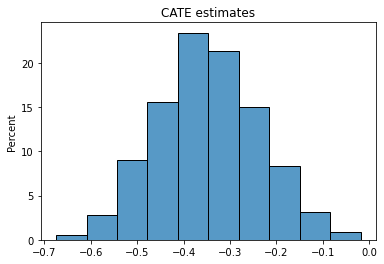

In [86]:
# Do not use this for assessing heterogeneity. See text above.
sns.histplot( tau_hat, stat = "percent", bins = 10)
plt.title("CATE estimates")


If the histogram is concentrated at a point, we may simply be underpowered: our method was not able to detect any heterogeneity, but maybe it would detect it if we had more data. If the histogram is spread out, we may be overfitting: our model is producing very noisy estimates $\widehat{\tau}(x)$, but in fact the true  $\tau(x)$ can be much smoother as a function of $x$.

The `CausalForest` package also produces a measure of variable importance that indicates how often a variable was used in a tree split. Again, much like the histogram above, this can be a rough diagnostic, but it should not be interpreted as indicating that, for example, variable with low importance is not related to heterogeneity. The reasoning is the same as the one presented in the causal trees section: if two covariates are highly correlated, the trees might split on one covariate but not the other, even though both (or maybe neither) are relevant in the true data-generating process.

In [88]:
importance = pd.DataFrame({"covariaties" : list(X.columns), "values" : est1.feature_importances()})

In [89]:
importance.sort_values('values', ascending = False)

,covariaties,values
1,polviews,0.676524
2,income,0.222522
3,educ,0.053710
0,age,0.036800
4,marital,0.007500
5,sex,0.002944


#### Data-driven subgroups

Just as with causal trees, we can use causal forests to divide our observations into subgroups. In place of leaves, we'll rank observation into (say) quintiles according to their estimated CATE prediction; see, e.g., [Chernozhukov, Demirer, Duflo, Fernández-Val (2020)](https://arxiv.org/abs/1712.04802) for similar ideas.

There's a subtle but important point that needs to be addressed here. As we have mentioned before, when predicting the conditional average treatment effect $\tau(X_i)$ for observation $i$ we should in general avoid using a model that was fitted using observation $i$. This sort of sample splitting (which we called **honesty** above) is one of the required ingredients to get unbiased estimates of the CATE using the methods described here. However, when ranking estimates of two observations $i$ and $j$, we need something a little stronger: we must ensure that the model was not fit using _either_ $i$ _or_ $j$'s data. 

One way of overcoming this obstacle is simple. First, divide the data into $K$ folds (subsets). Then, cycle through the folds, fitting a CATE model on $K-1$ folds. Next, for each held-out fold, _separately_ rank the unseen observations into $Q$ groups based on their prediction  (i.e., if $Q=5$, then we rank observations by estimated CATE into "top quintile", "second quintile", and so on). After concatenating the independent rankings together, we can study the differences in observations in each rank-group. 

[This gist](https://gist.github.com/halflearned/bea4e5137c0c81fd18a75f682da466c8) computes the above for `grf`, and it should not be hard to modify it so as to replace forests by any other non-parametric method. However, for `grf` specifically, there's a small trick that allows us to obtain a valid ranking: we can pass a vector of fold indices to the argument `clusters` and rank observations within each fold. This works because estimates for each fold ("cluster")   trees are computed using trees that were not fit using observations from that fold. Here's how to do it. 


In [90]:
fmla = '0+age+polviews+income+educ+marital+sex'
desc = patsy.ModelDesc.from_formula(fmla)
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")

T = data.loc[ : ,"w"]
Y = data.loc[ : ,"y"]
X = matrix
W = None 


In [91]:

def cluster_causal_forest(X,T,Y, cluster):        
        
        base = pd.concat([Y,T], axis = 1)
        
        for i in range(cluster):
        
            index=range(X.shape[0]) 
            a = np.array_split(np.array(index),cluster)[i]  ## split index
            
            Y = base.drop(base.iloc[list(a),:].index).iloc[:,0]
            T = base.drop(base.iloc[list(a),:].index).iloc[:,1]
            XX = X.drop(X.iloc[list(a),:].index)
            causal = CausalForest(n_estimators=2000, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
            causal.fit(XX,T,Y)
            
            tau_hat = causal.predict(X=X.iloc[list(a),:]).flatten() # tau(X) estimates using validation data
            vector = i*np.ones( len(list(a)) ) + 1
            globals()[f'data_{i}'] = pd.DataFrame({"tau_hat":tau_hat, "Cluster":vector})
                                                    
        
       
        tau_predict = data_0.copy()

        for k in range(1,cluster):
            tau_predict = tau_predict.append(globals()[f'data_{k}'] , ignore_index=True)
            
        
        
        return tau_predict

In [92]:
# Valid randomized data and observational data with unconfoundedness+overlap.
# Note: read the comments below carefully. 
# In randomized settings, do not estimate forest.e and e.hat; use known assignment probs.

#
# Prepare dataset
fmla = '0+age+polviews+income+educ+marital+sex'
desc = patsy.ModelDesc.from_formula(fmla)
matrix = patsy.dmatrix(fmla, data, return_type = "dataframe")

T = data.loc[ : ,"w"]
Y = data.loc[ : ,"y"]
X = matrix
W = None 


# Number of rankings that the predictions will be ranking on 
# (e.g., 2 for above/below median estimated CATE, 5 for estimated CATE quintiles, etc.)
num_rankings = 5  

# Prepare for data.splitting
# Assign a fold number to each observation.
# The argument 'clusters' in the next step will mimick K-fold cross-fitting.
num_folds = 10

# Estimate a causal forest.

tau_hat_cluster = cluster_causal_forest(X,T,Y,  cluster = num_folds)

data['ranking'] = np.nan

for i in range(1,num_folds+1):
    split = tau_hat_cluster.Cluster == i
    index = tau_hat_cluster[split].index
    tau_quantile = np.quantile(tau_hat_cluster[split].iloc[:,0], list(np.arange(0,1.1,0.2)))
    labels =[i for i in range(1,6)]
    data.loc[index , ["ranking"]] = pd.cut(tau_hat_cluster[split]["tau_hat"], 
                                               tau_quantile , right=False, labels=labels)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [93]:
# Valid only in randomized settings.
# Average difference-in-means within each ranking

# Formula y ~ 0 + ranking + ranking:w
fmla = 'y ~ 0 + C(ranking) + w:C(ranking)'
ols = smf.ols(fmla, data=data).fit(cov_type='HC2')

# Retrieve the interaction coefficients
ols_1 = ols.summary2().tables[1].reset_index()
ols_ate = ols_1.loc[ols_1["index"].str.contains("w:")].iloc[:,1:3]
ols_ate['method'] = "ols"
ols_ate['ranking'] = [f'Q{j}' for j in range(1,6)]
order = [2,3,0,1] # setting column's order
ols_ate = ols_ate[[ols_ate.columns[i] for i in order]]

In [94]:
ols_ate.rename({'Coef.': 'Estimate', 'Std.Err.': 'se'}, axis=1, inplace = True) 
ols_ate

,method,ranking,Estimate,se
5,ols,Q1,-0.434987,0.011334
6,ols,Q2,-0.395820,0.011269
7,ols,Q3,-0.364954,0.010913
8,ols,Q4,-0.322345,0.010519
9,ols,Q5,-0.220181,0.009833


In [95]:
# Computing AIPW scores.

regr = RegressionForest(max_depth=50, random_state=123,
                        n_estimators=2000)

e_hat = regr.fit(X, T).predict(X).flatten() # P[W=1|X]
m_hat = regr.fit(X, Y).predict(X).flatten() # E[Y|X]


# Estimating mu.hat(X, 1) and mu.hat(X, 0) for obs in held-out sample
# Note: to understand this, read equations 6-8 in this vignette:
# https://grf-labs.github.io/grf/articles/muhats.html
mu_hat0 = m_hat - e_hat * tau_hat        # E[Y|X,W=0] = E[Y|X] - e(X)*tau(X)
mu_hat1 = m_hat + (1 - e_hat) * tau_hat  # E[Y|X,W=1] = E[Y|X] + (1 - e(X))*tau(X)

# AIPW scores
data['aipw_scores'] = tau_hat + T / e_hat * (Y -  mu_hat1) - (1 - T) / (1 - e_hat) * (Y -  mu_hat0)

fmla = 'aipw_scores ~ 0 + C(ranking)'
ols = smf.ols(fmla,data).fit(cov_type='HC2')

# Retrieve the interaction coefficients
ols = ols.summary2().tables[1].reset_index()
forest_ate = ols.loc[ols["index"].str.contains("ranking")].iloc[:,1:3]
forest_ate['method'] = "apiw"
forest_ate['ranking'] = [f'Q{j}' for j in range(1,6)]
order = [2,3,0,1] # setting column's order
forest_ate = forest_ate[[forest_ate.columns[i] for i in order]]
forest_ate.rename({'Coef.': 'Estimate', 'Std.Err.': 'se'}, axis=1, inplace = True) 
forest_ate

,method,ranking,Estimate,se
0,apiw,Q1,-0.434726,0.010768
1,apiw,Q2,-0.399149,0.010537
2,apiw,Q3,-0.362827,0.010320
3,apiw,Q4,-0.321187,0.009990
4,apiw,Q5,-0.216252,0.009182


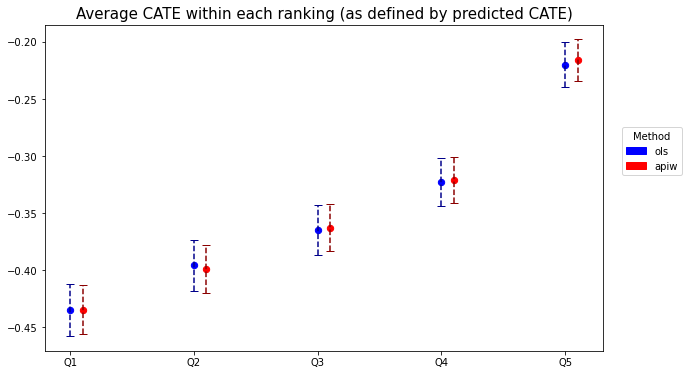

In [96]:
# Concatenate the two results.
res = pd.concat([forest_ate, ols_ate])

# Plotting the point estimate of average treatment effect 
# and 95% confidence intervals around it.
# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(10, 6))


ax.scatter(x=res['ranking'].unique(), 
         marker='o', s=40, 
         y=res[res.method == "ols"]['Estimate'], color = "blue")

ax.scatter(x=np.arange(0.1,5,1), 
         marker='o', s=40, 
         y=res[res.method == "apiw"]['Estimate'], color = "red")

eb1 = plt.errorbar(x=res['ranking'].unique(), y=res[res.method == "ols"]['Estimate'],
            yerr= 2*res[res.method == "ols"]['se'],
            color = 'darkblue', ls='', capsize = 4)
eb1[-1][0].set_linestyle('--')

eb2 = plt.errorbar(x=np.arange(0.1,5,1), y=res[res.method == "apiw"]['Estimate'],
            yerr= 2*res[res.method == "apiw"]['se'],
            color = 'darkred', ls='', capsize = 4)
eb2[-1][0].set_linestyle('--')

# Set title & labels
plt.title('Average CATE within each ranking (as defined by predicted CATE)',fontsize=15)

# add legend

red_patch = mpatches.Patch(color='red', label='apiw')
blue_patch = mpatches.Patch(color='blue', label='ols')

plt.legend(title = "Method", handles=[blue_patch,red_patch],  bbox_to_anchor=(1.15, 0.7))
    
plt.show()


When there isn't much detectable heterogeneity, the plot above can end up being non-monotonic. This can mean that the number of observations is too small for us to be able to detect subgroups with relevant differences in treatment effect.

<font size=1>
As an exercise, try running the previous two snippets on few data points (e.g., the first thousand observations only). You will likely see the "non-monotonicity" phenomenon just described.
</font>

Next, as we did for leaves in a causal tree, we can test e.g., if the prediction for groups 2, 3, etc. are larger than the one in the first group. Here's how to do it based on a difference-in-means estimator. Note the Romano-Wolf multiple-hypothesis testing correction.

In [97]:
# Valid in randomized settings only.

# y ~ ranking + w + ranking:w

fmla = 'y ~  C(ranking) + w + w:C(ranking)'
ols = smf.ols(fmla, data=data).fit()

# Retrieve the interaction coefficients
ols_1 = ols.summary2().tables[1].reset_index()
interact = ols_1.loc[ols_1["index"].str.contains("w:")]
ols_ate = summary_rw_lm(ols, indices=interact)
ols_ate['ranking'] = [f'Rank {j} - Rank 1' for j in range(2,6)]
order = [5,1,2,3,4] # setting column's order
ols_ate = ols_ate[[ols_ate.columns[i] for i in order]]
ols_ate.rename({'Coef.': 'Estimate', 'Std.Err.': 'se', 'ranking': 'Comparative'}, axis=1, inplace = True) 
ols_ate


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Comparative,Estimate,se,Orig.p-value,Adj. p-value
6,Rank 2 - Rank 1,0.039167,0.014772,8.021603e-03,0.0084
7,Rank 3 - Rank 1,0.070032,0.014765,2.114420e-06,0.0000
8,Rank 4 - Rank 1,0.112642,0.014758,2.368220e-14,0.0000
9,Rank 5 - Rank 1,0.214805,0.014772,9.849671e-48,0.0000


Here's how to do it for AIPW-based estimates, again with Romano-Wolf correction for multiple hypothesis testing. 

In [98]:
# Valid in randomized and observational settings with unconfoundedness+overlap.

# Using AIPW scores computed above

fmla = 'aipw_scores ~  1 + C(ranking)'
ols = smf.ols(fmla, data=data).fit()

# Retrieve the interaction coefficients
ols_1 = ols.summary2().tables[1].reset_index()
interact = ols_1.loc[1:num_rankings +1 ,:]
forest_ate = summary_rw_lm(ols, indices=interact)
forest_ate['ranking'] = [f'Rank {j} - Rank 1' for j in range(2,6)]
order = [5,1,2,3,4] # setting column's order
forest_ate = forest_ate[[forest_ate.columns[i] for i in order]]
forest_ate.rename({'Coef.': 'Estimate', 'Std.Err.': 'se', 'ranking': 'Comparative'}, axis=1, inplace = True) 
forest_ate




A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Comparative,Estimate,se,Orig.p-value,Adj. p-value
1,Rank 2 - Rank 1,0.035577,0.014387,1.341193e-02,0.0142
2,Rank 3 - Rank 1,0.071899,0.014391,5.884874e-07,0.0000
3,Rank 4 - Rank 1,0.113539,0.014392,3.157459e-15,0.0000
4,Rank 5 - Rank 1,0.218474,0.014396,8.118727e-52,0.0000


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


[Text(0.5, 0, 'Q1'),
 Text(1.5, 0, 'Q2'),
 Text(2.5, 0, 'Q3'),
 Text(3.5, 0, 'Q4'),
 Text(4.5, 0, 'Q5')]

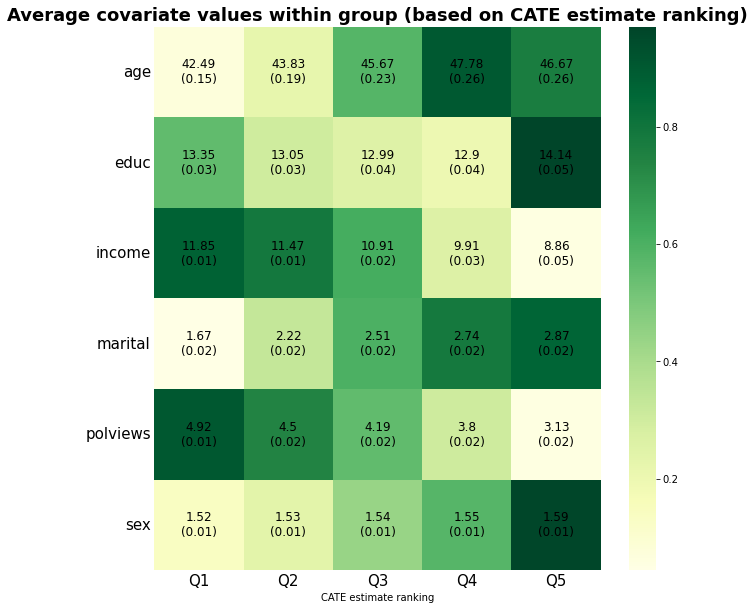

In [99]:
df = pd.DataFrame()

for var_name in covariates:
    form2 = var_name + " ~ " + "0" + "+" + "C(ranking)"
    ols = smf.ols(formula=form2, data=data).fit(cov_type = 'HC2').summary2().tables[1].iloc[:, 0:2]
    
    
    # Retrieve results
    toget_index = ols["Coef."]
    index = toget_index.index
    cova1 = pd.Series(np.repeat(var_name,num_rankings), index = index, name = "covariate")
    avg = pd.Series(ols["Coef."], name="avg")
    stderr = pd.Series(ols["Std.Err."], name = "stderr")
    ranking = pd.Series(np.arange(1,num_rankings+1), index = index, name = "ranking")
    scaling = pd.Series(norm.cdf((avg - np.mean(avg))/np.std(avg)), index = index, name = "scaling")
    data2 = pd.DataFrame(data=X, columns= covariates)
    variation1= np.std(avg) / np.std(data2[var_name])
    variation = pd.Series(np.repeat(variation1, num_rankings), index = index, name = "variation")
    labels = pd.Series(round(avg,2).astype('str') + "\n" + "(" + round(stderr, 2).astype('str') + ")", index = index, name = "labels")
    
    # Tally up results
    df1 = pd.DataFrame(data = [cova1, avg, stderr, ranking, scaling, variation, labels]).T
    df = df.append(df1)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df = df.sort_values(by = ["variation", "covariate"], ascending = False)

df = df.iloc[0:(8*num_rankings), :]
df1 = df.pivot(index = "covariate", columns = "ranking", values = ["scaling"]).astype(float)
labels =  df.pivot(index = "covariate", columns = "ranking", values = ["labels"]).to_numpy()

# plot heatmap
ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(df1, 
                 annot=labels,
                 annot_kws={"size": 12, 'color':"k"},
                 fmt = '',
                 cmap = "YlGn",
                 linewidths=0,
                 xticklabels = ranking)
plt.tick_params( axis='y', labelsize=15, length=0, labelrotation=0)
plt.tick_params( axis='x', labelsize=15, length=0, labelrotation=0)
plt.xlabel("CATE estimate ranking", fontsize= 10)
plt.ylabel("")
ax.set_title("Average covariate values within group (based on CATE estimate ranking)", fontsize=18, fontweight = "bold")
(ax.set_xticklabels(["Q1", "Q2", "Q3", "Q4","Q5"], size=15))

#### Best linear projection

This function provides a doubly robust fit to the linear model $\widehat{\tau}(X_i) = \beta_0 + A_i'\beta_1$, where $A_i$ can be a subset of the covariate columns. The coefficients in this regression are suggestive of general trends, but they should not be interpret as partial effects -- that would only be true if the true model were really linear in covariates, and that's an assumption we shouldn't be willing to make in general

In [101]:
# dataset for best linear proyection
X['tau_hat'] = tau_hat

smf.ols('tau_hat ~ age+polviews+income+educ+marital+sex',d).fit(cov_type = 'HC3').summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-0.194487,0.004157,-46.784878,0.000000e+00,-0.202635,-0.186340
age,0.001362,0.000031,43.386983,0.000000e+00,0.001300,0.001423
polviews,-0.033850,0.000367,-92.257380,0.000000e+00,-0.034569,-0.033131
income,-0.019321,0.000205,-94.304034,0.000000e+00,-0.019723,-0.018920
educ,0.008714,0.000193,45.253903,0.000000e+00,0.008336,0.009091
marital,0.008870,0.000317,27.986121,2.397396e-172,0.008249,0.009491
sex,-0.004628,0.000981,-4.720433,2.353431e-06,-0.006550,-0.002707


#### Partial dependence

It may also be interesting to examine how our CATE estimates behave when we change a single covariate, while keeping all the other covariates at a some fixed value. In the plot below we evaluate a variable of interest across quantiles, while keeping all other covariates at their median. 

It is important to recognize that by keeping some variables at their median we may be evaluating the CATE at $x$ values in regions where there are few or no data points. Also, it may be the case that varying some particular variable while keeping others fixed may just not be very interesting.

In what follows we'll again use `causal_forest` predictions, along with their variance estimates (set `estimate.variances=TRUE` when predicting to we get estimates of the asymptotic variance of the prediction for each point). Since `grf` predictions are asymptotically normal, we can construct 95\% confidence intervals in the usual manner (i.e., $\hat{\tau}(x) \pm 1.96\sqrt{\widehat{\text{Var}}(\hat{\tau}(x))}$).

In [102]:
selected_covariate = "polviews"
other_covariates = ["age", "income", "educ", "marital", "sex"]

# Fitting a forest 
# (commented for convenience; no need re-fit if already fitted above)
fmla = '0+age+polviews+income+educ+marital+sex'


grid_size = 7 


covariate_grid  = np.array_split(data[selected_covariate].sort_values().unique(),grid_size)

# Take median of other covariates 

median = data[other_covariates].median(axis = 0).to_numpy().reshape(1,5)

# duplicates rows 

data_grid = pd.concat([pd.DataFrame(median, columns = other_covariates)]*grid_size)
data_grid[selected_covariate ] = [i[0] for i in covariate_grid]

# Expand the data
X_grid = patsy.dmatrix(fmla, data_grid, return_type = "dataframe")

tau_hat = est1.predict(X=X_grid).flatten() 
tau_hat_ci = est1.predict_interval(X=X_grid)
tau_hat_se  = ((tau_hat_ci[1]-tau_hat_ci[0])/2).flatten()

FixedFormatter should only be used together with FixedLocator


[Text(0.0, 0, '0'),
 Text(1.0, 0, '1'),
 Text(2.0, 0, '2'),
 Text(3.0, 0, '3'),
 Text(4.0, 0, '4'),
 Text(5.0, 0, '5'),
 Text(6.0, 0, '6'),
 Text(7.0, 0, '7'),
 Text(8.0, 0, '')]

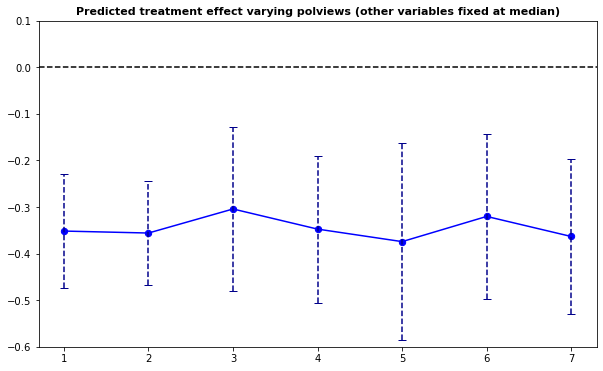

In [103]:
selected_covariate = "polviews"
other_covariates = ["age", "income", "educ", "marital", "sex"]

# Fitting a forest 
# (commented for convenience; no need re-fit if already fitted above)
fmla = '0+age+polviews+income+educ+marital+sex'


grid_size = 7 


covariate_grid  = np.array_split(data[selected_covariate].sort_values().unique(),grid_size)

# Take median of other covariates 

median = data[other_covariates].median(axis = 0).to_numpy().reshape(1,5)

# duplicates rows 

data_grid = pd.concat([pd.DataFrame(median, columns = other_covariates)]*grid_size)
data_grid[selected_covariate ] = [i[0] for i in covariate_grid]

# Expand the data
X_grid = patsy.dmatrix(fmla, data_grid, return_type = "dataframe")

tau_hat = est1.predict(X=X_grid).flatten() 
tau_hat_ci = est1.predict_interval(X=X_grid) 
tau_hat_se  = ((tau_hat_ci[1]-tau_hat_ci[0])/2).flatten() 

1# Plot predictions for each group and 95% confidence intervals around them.
fig, ax = plt.subplots(figsize=(10, 6))


ax.scatter(x=data_grid[selected_covariate], 
         marker='o', s=40, 
         y=tau_hat, color = "blue")

ax.plot(data_grid[selected_covariate], tau_hat, color = "blue")

eb1 = plt.errorbar(x=data_grid[selected_covariate], y=tau_hat,
            yerr= tau_hat_se,
            color = 'darkblue', ls='', capsize = 4)
eb1[-1][0].set_linestyle('--')

plt.ylim(-0.6, 0.1)
plt.axhline(y=0, color = 'black').set_linestyle('--')
ax.set_title(f"Predicted treatment effect varying {selected_covariate} (other variables fixed at median)",
             fontsize=11, fontweight = "bold")
(ax.set_xticklabels(range(0,8), size=10))

In [104]:
selected_covariates = ['polviews','age' ]
other_covariates = ["income", "educ", "marital", "sex"]
# Compute a grid of values appropriate for the selected covariate
# See other options for constructing grids in the snippet above.

x1_grid_size = 7
x2_grid_size = 5
x1_grid = np.array_split(data[selected_covariate].sort_values().unique(),grid_size)
x2_grid = np.quantile(data[selected_covariates[1]], list(np.arange(0,1.01,1/4)))

# Take median of other covariates 

median = data[other_covariates].median(axis = 0).to_numpy().reshape(1,4)

# duplicates rows 

data_grid = pd.concat([pd.DataFrame(median, columns = other_covariates)]*(x1_grid_size))
data_grid[selected_covariates[0]] =  [i[0] for i in covariate_grid]
data_grid = pd.concat([data_grid]*(x2_grid_size))
data_grid[selected_covariates[1]] =  list(pd.Series(x2_grid).repeat(7))

# Expand the data
X_grid = patsy.dmatrix(fmla, data_grid, return_type = "dataframe")

tau_hat = est1.predict(X=X_grid).flatten() 
tau_hat_ci = est1.predict_interval(X=X_grid) 
tau_hat_se  = ((tau_hat_ci[1]-tau_hat_ci[0])/2).flatten() 

df = X_grid
df['tau_hat'] = tau_hat
df['tau_hat_se'] = tau_hat_se

Text(0.5, 1.0, 'Predicted treatment effect varying polviews andage (other variables fixed at median)')

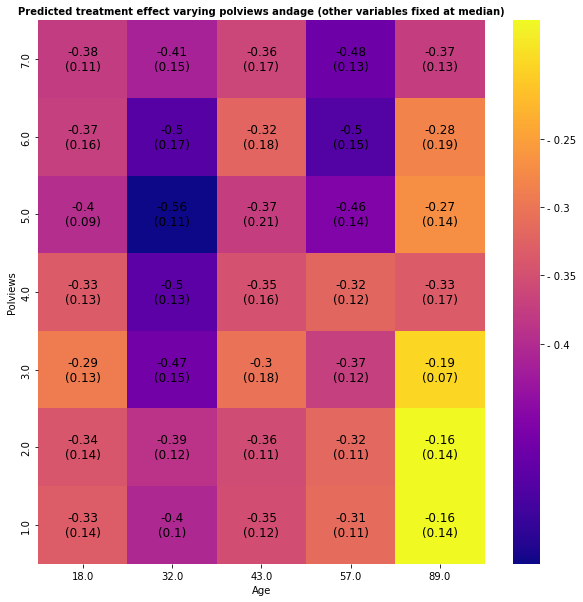

In [105]:
# order dataset
df = df.sort_values(by = ["polviews","age"], ascending = [False,True])
labels = np.array(round(df.tau_hat,2).astype('str') + "\n" + "(" + round(df.tau_hat_se, 2).astype('str') + ")")
labels = labels.reshape(7,5) # reshape labels 
df = df.pivot("polviews","age","tau_hat") # reshape dataset
df = df.sort_values(by = ["polviews"], ascending = False)

cbar_ticks = [-0.4,-0.35,-0.3,-0.25]
ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(df,
                 annot=labels,
                 annot_kws={"size": 12, 'color':"k"},
                 fmt = '',
                 cmap = "plasma",
                 linewidths=0,
                cbar_kws={"pad":0.05, "ticks": cbar_ticks})
cbar = ax.collections[0].colorbar
cbar.set_ticklabels(['- 0.4', '- 0.35', '- 0.3', '- 0.25'])
plt.xlabel("Age", fontsize= 10)
plt.ylabel("Polviews", fontsize= 10)
ax.set_title(f"Predicted treatment effect varying {selected_covariates[0]} and{selected_covariates[1]} (other variables fixed at median)",
             fontsize=10, fontweight = "bold")

## Further reading

A readable summary of different method for hypothesis testing correction is laid out in the introduction to [Clarke, Romano and Wolf (2009)](http://ftp.iza.org/dp12845.pdf).

[Athey and Wager (2019)](https://arxiv.org/abs/1902.07409) shows an application of causal forests to heterogeity analysis in a setting with clustering.